In [568]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
print(plt_styles)

plt.style.use(plt_styles[7])


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [569]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [570]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [571]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [572]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [573]:
toolbox = base.Toolbox()

In [574]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\Ivan\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Ivan\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [575]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [576]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance
    
    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))

def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)
    
    for i, car in enumerate(individual):
        v_r = cars_rides[car]
        
        if v_r is None:
            v_r = []
            
        ride = rides[i]
        v_r.append([i, ride])
        
        cars_rides[car] = v_r

    return cars_rides

def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [577]:
def calc_fitness(car, car_rides):
    fitness = 0
    penalty = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, adapted_ride = ride
        origin = [a, b]
        destiny = [x, y]

        adapted_car = adapted[car]

        if adapted_car == 0 and adapted_ride == 1:
            penalty += 10

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness, penalty


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0
    penalty = 0

    for car, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness, _penalty = calc_fitness(car, car_rides)
            fitness += _fitness
            penalty += _penalty

    return fitness, penalty


In [578]:

NIND = 30

pop = toolbox.population(n=NIND)
hof = tools.ParetoFront()
# print(f"Population: {pop}")

In [579]:
ind = toolbox.individual()

# print("Individuo ANTES de evaluar")
# print(ind)
# print(ind.fitness.valid)
# print("\n")

# ind.fitness.values = eval_ind(ind)

# print("Individuo TRAS evaluar")
# print(ind)
# print(ind.fitness.valid)
# print(ind.fitness)

In [580]:
INDPB = 0.2

toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [581]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
stats.register("std", np.std, axis=0)
stats.register("avg", np.average, axis=0)


In [582]:
NGEN = 20
MU = 50
LAMBDA = 2*MU
CXPB = 0.7
MUTPB = 0.2

pop, logbook = algorithms.eaMuPlusLambda(
    pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof, verbose=False)

best_sol = tools.selBest(pop, 1)[0]

In [583]:
print(f"El resultado de la evolución es:")
print(logbook)
# print(f"La mejor solucion encontrada es: {best_sol}")

El resultado de la evolución es:
gen	nevals	min              	max              	std                          	avg                              
0  	30    	[159257.    590.]	[170408.    750.]	[2867.88490568   39.22017621]	[164632.96666667    675.33333333]
1  	90    	[159595.    570.]	[170408.    730.]	[2636.44311306   43.72642222]	[166094.46    652.  ]            
2  	91    	[160397.    560.]	[171913.    730.]	[2335.12067363   49.59879031]	[167693.86    641.4 ]            
3  	90    	[163989.    560.]	[171913.    730.]	[1462.97262162   51.10772936]	[168907.22    632.  ]            
4  	93    	[165772.    500.]	[171913.    740.]	[1910.40839875   53.96332088]	[169143.1    608.6]              
5  	81    	[160751.    500.]	[173553.    750.]	[2026.70914233   49.56450343]	[170000.18    594.4 ]            
6  	89    	[163211.    490.]	[173553.    660.]	[2295.74286443   44.28317965]	[170088.98    573.  ]            
7  	89    	[164207.    490.]	[173553.    680.]	[2182.8465925   45.7383865]  	[1

In [584]:
def col(a, *n_cols):
    res = []
    for n in n_cols:
        b = np.array(a)[:, n]
        res.append(b)
    return res

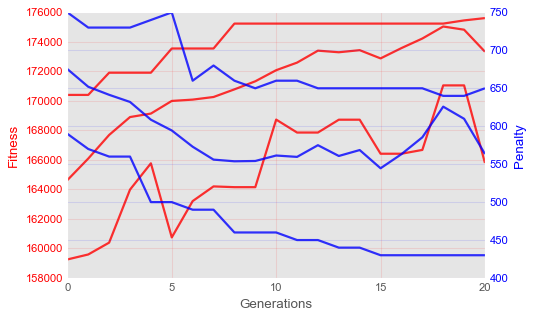

In [587]:
def plot_dif_scales(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    mins = lb.select("min")
    maxs = lb.select("max")

    fit_avgs, pen_avgs = col(avgs, 0, 1)
    fit_maxs, pen_maxs = col(maxs, 0, 1)
    fit_mins, pen_mins = col(mins, 0, 1)

    fig, ax = plt.subplots(figsize=(6, 4))

    c_ax, c_ax2 = ["r", "b"]
    linewidth = 2
    line_alpha = 0.8
    grid_alpha = 0.1

    ax.plot(gen, fit_avgs, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.plot(gen, fit_maxs, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.plot(gen, fit_mins, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.tick_params(axis="y", labelcolor=c_ax)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness", color=c_ax)
    ax.grid(alpha=grid_alpha, color=c_ax)

    ax2 = ax.twinx()
    ax2.plot(gen, pen_avgs, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.plot(gen, pen_maxs, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.plot(gen, pen_mins, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.tick_params(axis="y", labelcolor=c_ax2)
    ax2.set_ylabel("Penalty", color=c_ax2)
    ax2.grid(alpha=grid_alpha, color=c_ax2)

    plt.show()


plot_dif_scales(logbook)


In [ ]:
def plot_pareto(hof):
  fig, ax = plt.subplots(figsize=(6, 4))
  ax.scatter(hof)

plot_pareto(hof)

In [586]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")